# インポート

In [1]:

import numpy as np
import pandas as pd
import os
import pickle
import gc 

# 分布確認
import ydata_profiling as pdp

# 可視化
import matplotlib.pyplot as plt

# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder

# バリデーション
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

# 評価指標
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# モデリング: lightgbm
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

import sys

# matplotilbで日本語表示したい場合はこれをinstallしてインポートする
import japanize_matplotlib

from pathlib import Path

# Path().resolve()
# sys.path.append(os.path.join(Path().resolve(), '../source/'))

import seaborn as sns # Samuel Norman Seabornからとっている


## データ確認

In [2]:

df_train = pd.read_csv("../data/input/train.csv") # 学習データ
df_test = pd.read_csv("../data/input/test.csv")   # テストデータ

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


* テストデータのAgeに欠損値が多い
    * テストデータを補完するのはよいのかわからないが補間を試みる

In [4]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


## Age

欠損値があるので補完する。
* 平均値で補完する場合

In [5]:
df_train["Age_fillna_mean"] = df_train["Age"].fillna(df_train["Age"].mean())
df_train.loc[df_train["Age"].isnull(), ["Age", "Age_fillna_mean"]].head()

,Age,Age_fillna_mean
5,NaN,29.699118
17,NaN,29.699118
19,NaN,29.699118
26,NaN,29.699118
28,NaN,29.699118


* 持っているデータから推論する

In [6]:
# ------------ Age ------------
# Age を Pclass, Sex, Parch, SibSp からランダムフォレストで推定
from sklearn.ensemble import RandomForestRegressor

# 推定に使用する項目を指定
df_all = pd.concat([df_train, df_test], ignore_index=True, sort=False)
age_df = df_all[['Age', 'Pclass','Sex','Parch','SibSp']]

# ラベル特徴量をワンホットエンコーディング
age_df = pd.get_dummies(age_df)

# 学習データとテストデータに分離し、numpyに変換
known_age = age_df[age_df.Age.notnull()].values  
unknown_age = age_df[age_df.Age.isnull()].values

# 学習データをX, yに分離
X = known_age[:, 1:]  
y = known_age[:, 0]

# ランダムフォレストで推定モデルを構築
rfr = RandomForestRegressor(random_state=0, n_estimators=100, n_jobs=-1)
rfr.fit(X, y)

# 推定モデルを使って、テストデータのAgeを予測し、補完
predictedAges = rfr.predict(unknown_age[:, 1::])
print(df_test.Age.isnull())
df_all.loc[(df_all.Age.isnull()), 'Age'] = predictedAges 
df_test = df_all[df_all['Survived'].isnull()].drop('Survived',axis=1)


0      False
1      False
2      False
3      False
4      False
       ...  
413     True
414    False
415    False
416     True
417     True
Name: Age, Length: 418, dtype: bool


* 生存のピークは10再未満
* 死亡のピークは20後半

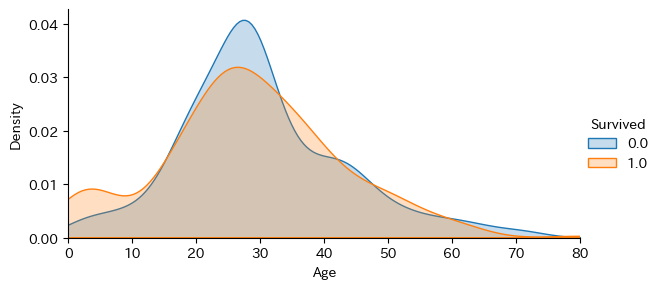

In [7]:

# 年齢別生存曲線と死亡曲線
facet = sns.FacetGrid(df_all[0:890], hue="Survived",aspect=2)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, df_train.loc[0:890,'Age'].max()))
facet.add_legend()
plt.show()

# Name の特徴梁探索

名前には敬称がある

In [8]:
df_train["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [9]:
* 敬称ごとの生存率を見てみる
  * "Futrelle, Mrs. Jacques Heath (Lily May Peel)"の分類
    * , で分けた[1]番目
    * . で分けた[0]番目
  * それぞれの数を数える

IndentationError: unexpected indent (2380117428.py, line 2)

In [ ]:
# 敬称の数を数える
title_list = df_train['Name'].map(lambda x: x.split(', ')[1].split('. ')[0]).to_list()

for title in set(title_list):
    count = title_list.count(title)
    print(str(title) + ":" + str(count))


Master:40
Mr:517
Dr:7
Mme:1
Mrs:125
Mlle:2
Capt:1
Col:2
Sir:1
the Countess:1
Ms:1
Jonkheer:1
Don:1
Lady:1
Miss:182
Rev:6
Major:2


* 少数のものをまとめる
* 同意のものをまとめる


<Axes: xlabel='Title', ylabel='Survived'>

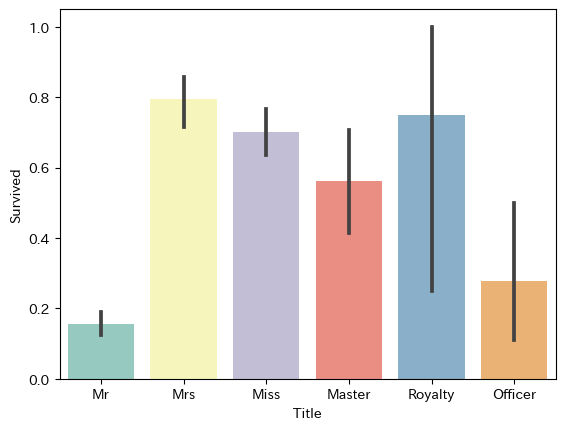

In [ ]:
# 敬称の分析
df_train['Title'] = df_train['Name'].map(lambda x: x.split(', ')[1].split('. ')[0])
# 同意のものをまとめる
df_train['Title'].replace(['Capt', 'Col', 'Major', 'Dr', 'Rev'], 'Officer', inplace=True)
df_train['Title'].replace(['Don', 'Sir',  'the Countess', 'Lady', 'Dona'], 'Royalty', inplace=True)
df_train['Title'].replace(['Mme', 'Ms'], 'Mrs', inplace=True)
df_train['Title'].replace(['Mlle'], 'Miss', inplace=True)
df_train['Title'].replace(['Jonkheer'], 'Master', inplace=True)
# データ表示
sns.barplot(x='Title', y='Survived', data=df_train, palette='Set3')

* 同じ苗字の人をまとめる

In [ ]:
# ------------ Surname ------------
# NameからSurname(苗字)を抽出
df_train['Surname'] = df_train['Name'].map(lambda name:name.split(',')[0].strip())

# 同じSurname(苗字)の出現頻度をカウント(出現回数が2以上なら家族)
df_train['FamilyGroup'] = df_train['Surname'].map(df_train['Surname'].value_counts()) 

* さらに女子供と男のグループに分ける

In [ ]:
# 家族で16才以下または女性の生存率
Female_Child_Group = df_train.loc[(df_train['FamilyGroup']>=2) & ((df_train['Age']<=16) | (df_train['Sex']=='female'))]
Female_Child_Group = Female_Child_Group.groupby('Surname')['Survived'].mean()
print(Female_Child_Group.value_counts())

Survived
1.000000    77
0.000000    27
0.750000     2
0.500000     1
0.333333     1
0.142857     1
Name: count, dtype: int64


In [ ]:
# 家族で16才超えかつ男性の生存率
Male_Adult_Group=df_train.loc[(df_train['FamilyGroup']>=2) & (df_train['Age']>16) & (df_train['Sex']=='male')]
Male_Adult_List=Male_Adult_Group.groupby('Surname')['Survived'].mean()
print(Male_Adult_List.value_counts())

Survived
0.000000    70
1.000000    14
0.500000     4
0.333333     1
Name: count, dtype: int64


* 生存率１００と０の極端なグループ分けができた

In [ ]:
# デッドリストとサバイブリストの作成
Dead_list = set(Female_Child_Group[Female_Child_Group.apply(lambda x:x==0)].index)
Survived_list = set(Male_Adult_List[Male_Adult_List.apply(lambda x:x==1)].index)

# デッドリストとサバイブリストの表示
print('Dead_list = ', Dead_list)
print('Survived_list = ', Survived_list)

# デッドリストとサバイブリストをSex, Age, Title に反映させる
df_train.loc[(df_train['Survived'].isnull()) & (df_train['Surname'].apply(lambda x:x in Dead_list)),\
             ['Sex','Age','Title']] = ['male',28.0,'Mr']
df_train.loc[(df_train['Survived'].isnull()) & (df_train['Surname'].apply(lambda x:x in Survived_list)),\
             ['Sex','Age','Title']] = ['female',5.0,'Mrs']

Dead_list =  {'Rice', 'Lefebre', 'Ford', 'Olsson', 'Arnold-Franchi', 'Sage', 'Danbom', 'Goodwin', 'Johnston', 'Barbara', 'Zabour', 'Elias', 'Jussila', 'Rosblom', 'Skoog', 'Cacic', 'Attalah', 'Oreskovic', 'Boulos', 'Van Impe', 'Lobb', 'Turpin', 'Vander Planke', 'Strom', 'Bourke', 'Panula', 'Palsson'}
Survived_list =  {'Dick', 'Beane', 'Taylor', 'Frauenthal', 'Flynn', 'Bishop', 'Goldenberg', 'Jussila', 'Nakid', 'Beckwith', 'Hoyt', 'Duff Gordon', 'Chambers', 'Daly'}


# Fare

* 運賃は場所とクラスが関係すると推測
  * 欠損値の場所とクラスをチェックする
    * Pclass:3, Embarked:S

In [19]:
df_test.loc[df_test["Fare"].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_fillna_mean
1043,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,NaN


* 欠損値を Embarked='S', Pclass=3 の平均値で補完

In [15]:
# 欠損値を Embarked='S', Pclass=3 の平均値で補完
fare = df_train.loc[(df_train['Embarked'] == 'S') & (df_train['Pclass'] == 3), 'Fare'].median()
print(fare)
df_train['Fare']=df_train['Fare'].fillna(fare)
#df_train['Fare'].info()
df_test['Fare'].info()

8.05
<class 'pandas.core.series.Series'>
Index: 418 entries, 891 to 1308
Series name: Fare
Non-Null Count  Dtype  
--------------  -----  
417 non-null    float64
dtypes: float64(1)
memory usage: 6.5 KB


# SibSp, Parch
* 家族として特徴量にする

In [20]:
# train_dataとtest_dataの連結
df_test['Survived'] = np.nan
df = pd.concat([df_train, df_test], ignore_index=True, sort=False)

In [21]:
# ----------- Family -------------
# Family = SibSp + Parch + 1 を特徴量とし、グルーピング
# 2～4：生存大
# 1, 5,6,7：中
# 8以上:小

df['Family'] = df['SibSp'] + df['Parch'] + 1
df.loc[(df['Family']>=2) & (df['Family']<=4), 'Family_label'] = 2
df.loc[(df['Family']>=5) & (df['Family']<=7) | (df['Family']==1), 'Family_label'] = 1  # == に注意
df.loc[(df['Family']>=8), 'Family_label'] = 0

<Axes: xlabel='Family', ylabel='Survived'>

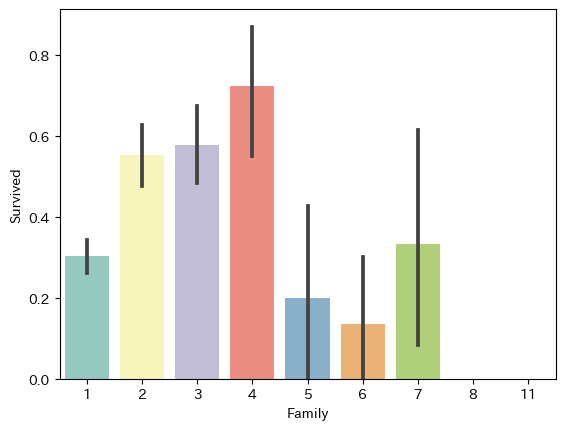

In [22]:
# データ表示
sns.barplot(x='Family', y='Survived', data=df, palette='Set3')

# Ticket

* Ticket番号が同じ人数別の生存率

{'CA. 2343': 11, 'CA 2144': 8, '1601': 8, 'PC 17608': 7, 'S.O.C. 14879': 7, '347077': 7, '347082': 7, '3101295': 7, '19950': 6, '113781': 6, '347088': 6, '382652': 6, '4133': 5, 'W./C. 6608': 5, 'PC 17757': 5, '349909': 5, '220845': 5, '113503': 5, '16966': 5, 'LINE': 4, 'C.A. 33112': 4, 'PC 17755': 4, 'C.A. 34651': 4, '12749': 4, 'PC 17760': 4, '230136': 4, 'SC/Paris 2123': 4, 'W./C. 6607': 4, 'PC 17483': 4, '2666': 4, 'C.A. 2315': 4, '17421': 4, '113760': 4, '24160': 4, '36928': 4, 'S.C./PARIS 2079': 3, '315153': 3, '371110': 3, 'PC 17761': 3, 'PC 17558': 3, '230080': 3, '363291': 3, '248727': 3, '2668': 3, '2678': 3, 'A/5. 851': 3, 'A/4 48871': 3, '370129': 3, '35273': 3, 'PC 17756': 3, '28220': 3, '345773': 3, '347080': 3, '2653': 3, 'C.A. 31029': 3, '33638': 3, 'C.A. 37671': 3, 'F.C.C. 13529': 3, '11767': 3, 'PC 17758': 3, '367226': 3, '19877': 3, 'SOTON/O.Q. 3101315': 3, 'C.A. 2673': 3, '239853': 3, '13502': 3, 'PC 17582': 3, '110413': 3, '110152': 3, '2650': 3, '248738': 3, '263

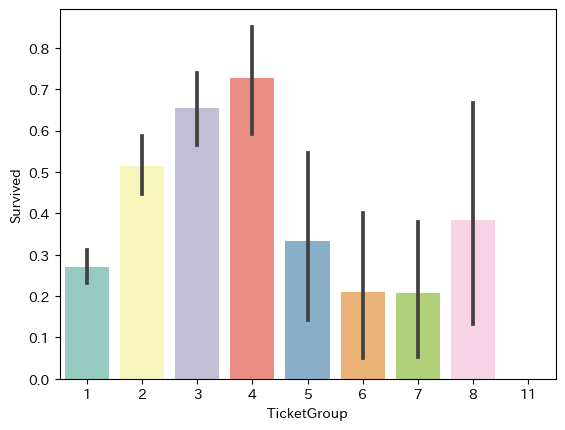

In [23]:
# 同一Ticketナンバーの人が何人いるかを特徴量として抽出
Ticket_Count = dict(df['Ticket'].value_counts())

print(Ticket_Count)

df['TicketGroup'] = df['Ticket'].map(Ticket_Count)
sns.barplot(x='TicketGroup', y='Survived', data=df, palette='Set3')
plt.show()

* 2〜4人の生存率が高
* 5〜8人と1人の生存率が中位
* 11人の生存率はゼロ
* 従って、3つにグルーピングします。

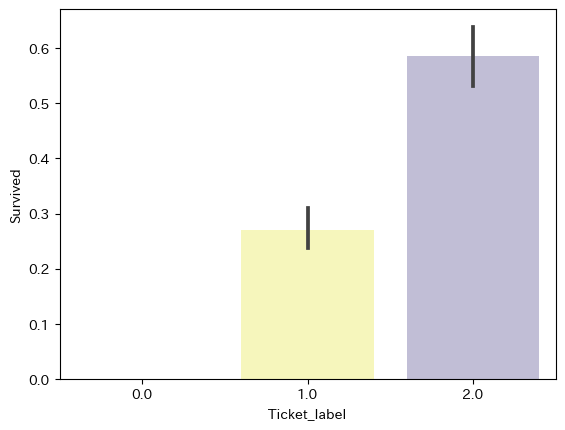

In [24]:
# 生存率で3つにグルーピング
df.loc[(df['TicketGroup']>=2) & (df['TicketGroup']<=4), 'Ticket_label'] = 2
df.loc[(df['TicketGroup']>=5) & (df['TicketGroup']<=8) | (df['TicketGroup']==1), 'Ticket_label'] = 1  
df.loc[(df['TicketGroup']>=11), 'Ticket_label'] = 0
sns.barplot(x='Ticket_label', y='Survived', data=df, palette='Set3')
plt.show()

# Cabin

In [27]:
df["Cabin"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1309 entries, 0 to 1308
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
295 non-null    object
dtypes: object(1)
memory usage: 10.4+ KB


* パターンごとの生存率を見る
* 欠損値は Unknownとする。補間はしない

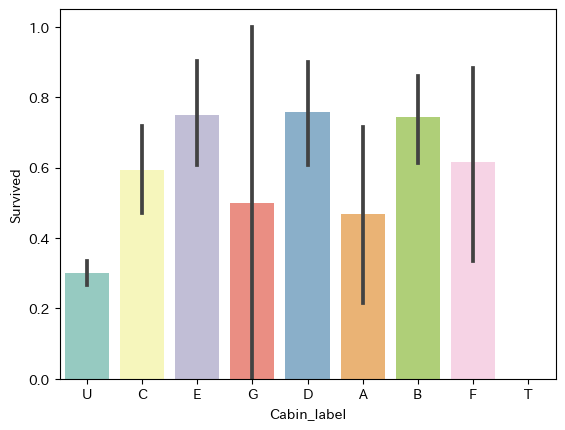

In [28]:
# ------------- Cabin ----------------
# Cabinの先頭文字を特徴量とする(欠損値は U )
df['Cabin'] = df['Cabin'].fillna('Unknown')
df['Cabin_label']=df['Cabin'].str.get(0)
sns.barplot(x='Cabin_label', y='Survived', data=df, palette='Set3')
plt.show()

# Embarked

In [33]:
# 欠損値の数
df["Embarked"].isnull().values.sum()

2

In [34]:
# 要素ごとのカウント
df["Embarked"].value_counts()

Embarked
S    914
C    270
Q    123
Name: count, dtype: int64

<Axes: xlabel='Embarked', ylabel='Survived'>

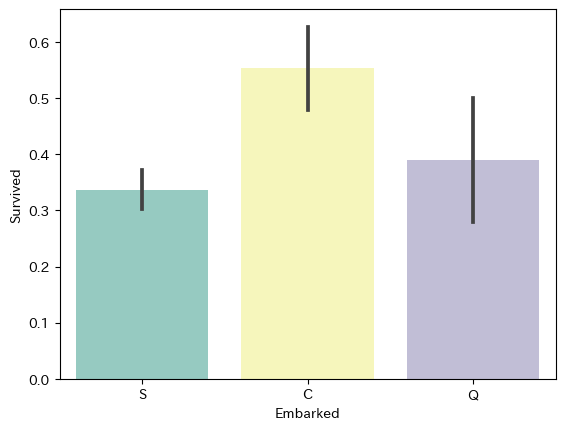

In [35]:
# 要素ごとの生存率
sns.barplot(x='Embarked', y='Survived', data=df, palette='Set3')

In [ ]:
# 欠損値は一番乗船者が多かったSで補完
df['Embarked'] = df['Embarked'].fillna('S') 